## Predicting Customer Churns with Classification Algorithms

The purpose of this project is to predict whether a telco customer will remain or leave the company, i.e. churn, by utilizing supervised learning in the form of classification. An example of why a company would employ this task is to identify exisiting customers that are likely to churn so they can allocate resource like promotional material in an effort to retain them. 

The data will be split into three set - 60% training, 20% validation, and 20% test. For this task, six classification algorthims are initially considered using cross-validation on the training set. Of those six, three are shortlisted for further modelling. For each of those models, the hyperparameters are tuned and the validation set is used to test the performance increase from the tuning. After a model is tuned, a precision and recall trade-off that is appropriate for the task is chosen for it. The final models are then tested on the validation set to compare performance. Finally, the models are tested once more on unseen data via the test set to determine the best performing model. 

In [314]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

# Cross Validation
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Classifiers 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Performance metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, average_precision_score
from sklearn.metrics import make_scorer

# Visualizing decision tree
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

In [365]:
import warnings
warnings.filterwarnings("ignore", message="F-score is ill-defined and being set to 0.0 due to no predicted samples.")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [1126]:
df = pd.read_csv("churn.csv" , sep=r'\s*,\s*', header=0, encoding='ascii', engine='python')
df1 = pd.read_csv("churn.csv", sep=r'\s*,\s*', header=0, encoding='ascii', engine='python')
df.head(5)

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [1138]:
# Calculate proportion of class labels in target feature.
df['churn'].value_counts(normalize=True).mul(100)

False    85.508551
True     14.491449
Name: churn, dtype: float64

From the above percentages, it is apparent that there is a class imbalance in the target feature. Only 15.5% of customers fall under the class True, i.e. churned customers. Several approaches are taken throughout the project to tackle the class imbalance.

<b> Preprocess data and create train, validate and test sets </b>

In [1136]:
# Encode international plan and voicemail plan into binary format. 
international_plan_class = pd.get_dummies(df['international plan'],drop_first=True).rename(columns={'yes':'international plan'})
voicemail_plan_class = pd.get_dummies(df['voice mail plan'],drop_first=True).rename(columns={'yes':'voice mail plan'})
# Apply One Hot Encoding to the State variable. 
state_class = df['state'].str.get_dummies()

In [4]:
df = df.drop(['international plan','voice mail plan', 'state', 'area code', 'phone number'], axis=1)

In [5]:
df = pd.concat([state_class, international_plan_class, voicemail_plan_class, df], axis=1)

In [6]:
y = df['churn']
X = df.drop(['churn'], axis=1)

In [7]:
# split data by 60% train set, 20% validation set, 20% test set. 
train_set_X, test_X, train_set_y, test_y = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
train_X, validate_X, train_y, validate_y = train_test_split(train_set_X, train_set_y, test_size=0.25, random_state=1)

For the SVM and KNN classifiers, continuous features will need to be scaled. Due to limitations experienced with the StandardScaler function, the split process will need to be duplicated. However random_state is employed to ensure the scaled and unscaled samples are identical. 

In [8]:
train_set_Xs, test_Xs, train_set_ys, test_ys = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
train_Xs, validate_Xs, train_ys, validate_ys = train_test_split(train_set_Xs, train_set_ys, test_size=0.25, random_state=1)

In [10]:
# Scaling continuous features. The features that have been encoded are left as-is. 
scaler = StandardScaler()

cols_scale = ['account length', 'number vmail messages', 'total day minutes', 
              'total day calls', 'total day charge', 'total eve minutes', 
              'total eve calls', 'total eve charge', 'total night minutes', 
              'total night calls', 'total night charge', 'total intl minutes', 
              'total intl calls', 'total intl charge', 'customer service calls']

train_Xs = train_Xs.copy()
validate_Xs = validate_Xs.copy()
test_Xs = test_Xs.copy()

train_Xs[cols_scale] = scaler.fit_transform(train_Xs[cols_scale]).astype(float)
validate_Xs[cols_scale] = scaler.fit_transform(validate_Xs[cols_scale]).astype(float)
test_Xs[cols_scale] = scaler.fit_transform(test_Xs[cols_scale]).astype(float)

## Compare algorithms using 5-fold cross-validation

5-fold cross-validation will be used on the test data to shortlist the three strongest performing algorithm. The metric used to determine performance is the f1-score for the class "True". This metric is chosen over accuracy due to class imbalance in the target feature. Class imbalance is treated further by employing stratified sampling with CV.

In [14]:
sk5fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
logreg_score = []
dtree_score = []
rf_score = []
gb_score = []
knn_score = []
svc_score = []

for train_index, test_index in sk5fold.split(train_X, train_y):
    X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
    y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]

    # Logistic Regression
    model_logreg = LogisticRegression(solver='lbfgs', max_iter=4000)
    model_logreg.fit(X_train, y_train)
    f1_logreg = f1_score(y_test, model_logreg.predict(X_test), average='binary')
    logreg_score.append(f1_logreg)    

    # Decision Tree   
    model_dtree = DecisionTreeClassifier()
    model_dtree.fit(X_train, y_train)
    f1_dtree = f1_score(y_test, model_dtree.predict(X_test), average='binary')
    dtree_score.append(f1_dtree)

    # Random Forest 
    model_rf = RandomForestClassifier(n_estimators=100)
    model_rf.fit(X_train, y_train)
    f1_rf = f1_score(y_test, model_rf.predict(X_test), average='binary')
    rf_score.append(f1_rf)

    # Gradient Boosting
    model_gb = GradientBoostingClassifier()
    model_gb.fit(X_train, y_train)
    f1_gb = f1_score(y_test, model_gb.predict(X_test), average='binary')
    gb_score.append(f1_gb)

    
for train_index, test_index in sk5fold.split(train_Xs, train_ys):
    Xs_train, Xs_test = train_Xs.iloc[train_index], train_Xs.iloc[test_index]
    ys_train, ys_test = train_ys.iloc[train_index], train_ys.iloc[test_index]

    # K Nearest Neighbors   
    model_knn = KNeighborsClassifier()
    model_knn.fit(Xs_train, ys_train)
    f1_knn = f1_score(ys_test, model_knn.predict(Xs_test), average='binary')
    knn_score.append(f1_knn)

    # Support Vector Machines    
    model_svc = SVC(gamma='scale')
    model_svc.fit(Xs_train, ys_train)
    f1_svc = f1_score(ys_test, model_svc.predict(Xs_test), average='binary')
    svc_score.append(f1_svc)

In [861]:
classifiers = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'KNN', 'SVM']
scores = [logreg_score, dtree_score, rf_score, gb_score, knn_score, svc_score]
average_f1 = []
for name in scores:
    average_f1.append(sum(name)/5*100)

models = pd.DataFrame(data=list(zip(classifiers, average_f1)),columns=['Classifier','Average f1'])
models

,Classifier,Average f1
0,Logistic Regression,29.163609
1,Decision Tree,66.231386
2,Random Forest,65.857698
3,Gradient Boosting,77.924837
4,KNN,35.369074
5,SVM,46.854457


(20, 80)

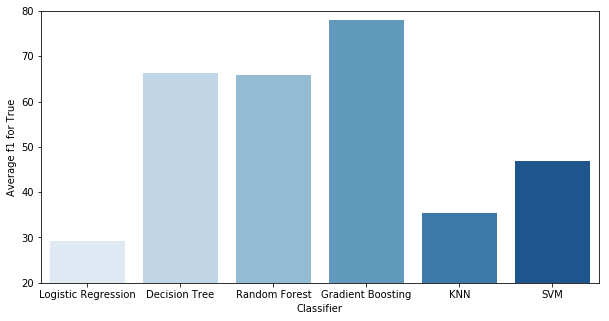

In [23]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Classifier', y='Average f1 for True', data = models, palette='Blues')
plt.ylim(20, 80)

Based on the results above we will proceed with the Decision Tree, Random Forest and Gradient Boosting for classification. The next step will involve optimizing the hyperparameters of each model by testing them on the validation set. 

## <b> Decision Tree as a Classifier </b> 

First, predict model on the validation set and use as a baseline to compare the performance increase from tuning hyperparamters.

In [24]:
predictions_dtree = model_dtree.predict(validate_X)

              precision    recall  f1-score   support

       False       0.95      0.96      0.96       564
        True       0.77      0.75      0.76       103

   micro avg       0.93      0.93      0.93       667
   macro avg       0.86      0.85      0.86       667
weighted avg       0.93      0.93      0.93       667





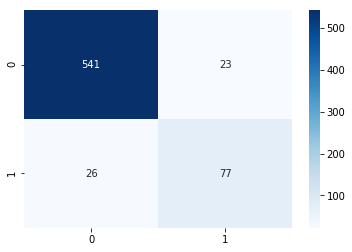

In [25]:
print(classification_report(validate_y,predictions_dtree))
print('\n')
sns.heatmap(confusion_matrix(validate_y,predictions_dtree), annot=True, cmap='Blues', fmt='g');

A grid search of all specified hyperparameters will be conducted to determine the optinimal combination of parameters. For the decision tree, three hyperparameters are under consideration - max_depth, min_samples_split, and min_samples_leaf.

Before running GridSearchCV, the evaluation metric and CV method must be defined.

In [594]:
# Create callable metric based on f1-score of True class.
f1_scorer = make_scorer(f1_score, pos_label=True)

# Define stratified sampling method to be used with GridSearchCV.
skfold = StratifiedKFold(n_splits=5)

In [521]:
param_grid = {'max_depth': range(1, 11), 'min_samples_leaf': range(1, 11), 'min_samples_split': range(2, 11), 
              'criterion': ['gini','entropy']}
gs_dtree = GridSearchCV(model_dtree, param_grid, cv=skfold, scoring=f1_scorer)
gs_dtree.fit(X_train,y_train)
print(gs_dtree.best_params_)

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 6}


In [524]:
# Evaluate new model using parameters above.
tuned_dtree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 6, min_samples_leaf = 1, min_samples_split = 6)
tuned_dtree.fit(X_train, y_train)
predictions_tuned_dtree = tuned_dtree.predict(validate_X)

              precision    recall  f1-score   support

       False       0.96      0.98      0.97       564
        True       0.90      0.80      0.85       103

   micro avg       0.96      0.96      0.96       667
   macro avg       0.93      0.89      0.91       667
weighted avg       0.95      0.96      0.95       667





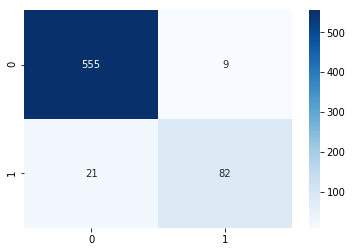

In [525]:
print(classification_report(validate_y, predictions_tuned_dtree))
print('\n')
sns.heatmap(confusion_matrix(validate_y, predictions_tuned_dtree), annot=True, cmap='Blues', fmt='g');

Performance increase from tuning can be observed. Using this new model we will plot precision against recall to visualize the trade-off and select a new decision threshold that fits our task.

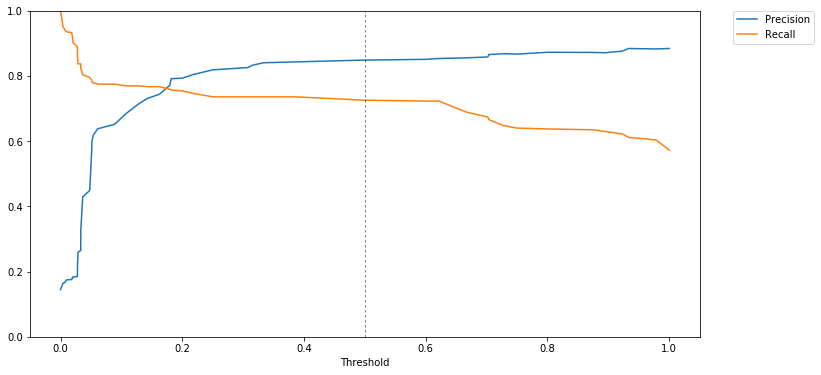

In [1030]:
# create function to plot PR curve.
def plot_pr_curve(model):
    y_scores = cross_val_predict(model, train_set_X, train_set_y, cv=5, method="predict_proba")
    precisions, recalls, thresholds = precision_recall_curve(train_set_y, y_scores[:, 1], pos_label=True)
    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, precisions[:-1], label="Precision")
    plt.plot(thresholds, recalls[:-1], label="Recall")
    plt.axvline(x=0.5, linewidth = 0.5, color = 'black', linestyle='--', dashes=(5, 5))
    plt.xlabel("Threshold")
    plt.ylim([0, 1])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Pass in tuned model into function
plot_pr_curve(tuned_dtree)
plt.show()

Ideally the model should not overlook customers who are potentially churning and falsely classify them as not. In other words it would be acceptable to increase recall at the expense of some precision. As per the PR curve, this means choosing a threshold value left of the default 50% threshold.

However based on the plot, it does not appear that much recall can be gained for a drop in precision. Various threshold levels are also tested using the code below. In conclusion, the default threshold of 50% is retained.

In [1050]:
threshold_dtree = 0.5
predictions_tuned_dtree = tuned_dtree.predict_proba(validate_X)
predictions_tuned_dtree = np.where(predictions_tuned_dtree[:,1] >= threshold_dtree, True, False)

              precision    recall  f1-score   support

       False       0.96      0.98      0.97       564
        True       0.90      0.80      0.85       103

   micro avg       0.96      0.96      0.96       667
   macro avg       0.93      0.89      0.91       667
weighted avg       0.95      0.96      0.95       667





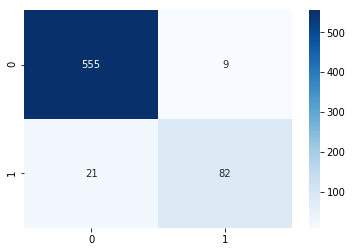

In [1051]:
print(classification_report(validate_y, predictions_tuned_dtree))
print('\n')
sns.heatmap(confusion_matrix(validate_y, predictions_tuned_dtree), annot=True, cmap='Blues', fmt='g');

The final model produces a precision of 90% and a recall of 80% for the True class. That is to say that the model guessed an observation to be in the class True 91 times and was right 82 of those times (90%). In addition, out of 103 observations that are actually in the class True, the model classified 82 of them as True (80%).

## <b> Random Forest as a Classifier </b>

The same approach to fine-tuning and selection of an approrpiate decision threshold is applied to the Random Forest classifer.

In [59]:
predictions_rf = model_rf.predict(validate_X)

              precision    recall  f1-score   support

       False       0.92      1.00      0.96       564
        True       1.00      0.50      0.67       103

   micro avg       0.92      0.92      0.92       667
   macro avg       0.96      0.75      0.81       667
weighted avg       0.93      0.92      0.91       667





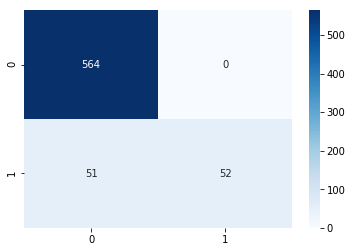

In [60]:
print(classification_report(validate_y,predictions_rf))
print('\n')
sns.heatmap(confusion_matrix(validate_y,predictions_rf), annot=True, cmap='Blues', fmt='g');

The purpose of the Random Forest technique is to take many overfitting trees (with high variance and low bias) and average them together. Therefore regularization of the tree in the model is not required.

In [556]:
param_grid = {'n_estimators': range(100,500,50), 'max_features': [10, 20, 30, 40, 50, 60, 68]}
gs_rf = GridSearchCV(model_rf, param_grid, cv=skfold, scoring=f1_scorer)
gs_rf.fit(X_train,y_train)
print(gs_rf.best_params_)

{'max_features': 40, 'n_estimators': 250}


In [557]:
tuned_rf = RandomForestClassifier(max_features = 40, n_estimators=250)
tuned_rf.fit(X_train, y_train)
predictions_tuned_rf = tuned_rf.predict(validate_X)

              precision    recall  f1-score   support

       False       0.96      0.99      0.98       564
        True       0.94      0.79      0.86       103

   micro avg       0.96      0.96      0.96       667
   macro avg       0.95      0.89      0.92       667
weighted avg       0.96      0.96      0.96       667





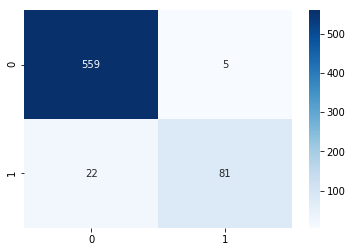

In [558]:
print(classification_report(validate_y,predictions_tuned_rf))
print('\n')
sns.heatmap(confusion_matrix(validate_y,predictions_tuned_rf), annot=True, cmap='Blues', fmt='g');

Again looking at the True class, increasing the number of trees and reducing the number of features to decide on a split results in a 58% increase in recall, with accurancy reduced by only 4%. This model will be used to plot the PR curve in the next step.

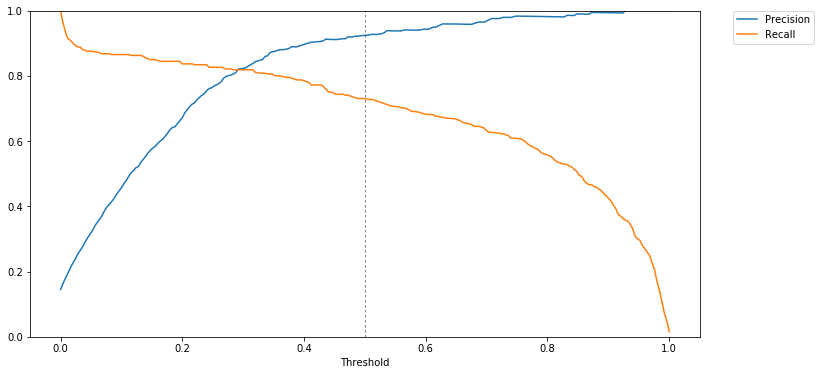

In [1031]:
plot_pr_curve(tuned_rf)
plt.show()

              precision    recall  f1-score   support

       False       0.97      0.98      0.98       564
        True       0.91      0.83      0.87       103

   micro avg       0.96      0.96      0.96       667
   macro avg       0.94      0.91      0.92       667
weighted avg       0.96      0.96      0.96       667





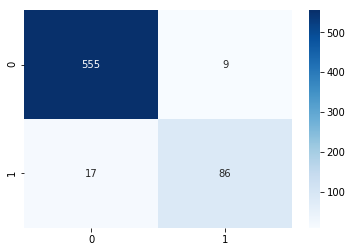

In [1053]:
# Set threshold to 40%
threshold_rf = 0.4
predictions_tuned_rf = tuned_rf.predict_proba(validate_X)
predictions_tuned_rf = np.where(predictions_tuned_rf[:,1] >= threshold_rf, True, False)
print(classification_report(validate_y,predictions_tuned_rf))
print('\n')
sns.heatmap(confusion_matrix(validate_y,predictions_tuned_rf), annot=True, cmap='Blues', fmt='g');

Setting the threshold to 40% reduces the precision from 94% to 91% but the recall increased from 79% to 83%. 

## <b> Gradient Boosting as a Classifier </b>

Gradient boosting works by adding subsequent decision trees to correct the mistakes made by the one before it. There are two groups of hyperparameters to consider with tuning gradient boosting models, tree specific and boosting specific parameters. 

An initial model set to default parameters is evaluated. next the boosting specific paramenters are tuned and the resulting model is compared with the initial model. Finally the tree specific parameters are tuned and the final model is comapred with previous models to observe any perfomance increase.

In [1067]:
model_gbt = GradientBoostingClassifier()
model_gbt.fit(X_train, y_train)
predictions_gbt = model_gbt.predict(test_X)
print(classification_report(test_y,predictions_gbt))

              precision    recall  f1-score   support

       False       0.94      0.99      0.96       570
        True       0.89      0.64      0.74        97

   micro avg       0.94      0.94      0.94       667
   macro avg       0.91      0.81      0.85       667
weighted avg       0.93      0.94      0.93       667



In [281]:
# Begin with evaluating a model set with default parameters. Metrics gernerated to compare performance differences from tuning.
model_gb1 = GradientBoostingClassifier()
model_gb1.fit(X_train, y_train)
predictions_gb1 = model_gb1.predict(validate_X)
print(classification_report(validate_y,predictions_gb1))

              precision    recall  f1-score   support

       False       0.96      0.99      0.98       564
        True       0.95      0.79      0.86       103

   micro avg       0.96      0.96      0.96       667
   macro avg       0.96      0.89      0.92       667
weighted avg       0.96      0.96      0.96       667



In [595]:
# Search for optimal combination of learning rate and number of estimators. 
param_grid = {'learning_rate': [0.3, 0.15, 0.1, 0.05, 0.01], 'n_estimators': range(50,500,50)}
gs_gb = GridSearchCV(model_gb, param_grid, cv=skfold, scoring=f1_scorer)
gs_gb.fit(X_train,y_train)
print(gs_gb.best_params_)

{'learning_rate': 0.15, 'n_estimators': 250}


In [643]:
# set learning rate to 0.15 and number of trees to 250. Then search for max number of features.  
model_gb1 = GradientBoostingClassifier(learning_rate=0.15, n_estimators=250)
param_grid_1 = {'max_features' : [10, 20, 30, 40, 50, 60, 68]}
gs_gb1 = GridSearchCV(model_gb1, param_grid_3, cv=skfold, scoring=f1_scorer)
gs_gb1.fit(X_train,y_train)
print(gs_gb1.best_params_)

{'max_features': 40}


In [606]:
# Set max_features to 40, search for subsample size. 
model_gb1a = GradientBoostingClassifier(learning_rate=0.15, n_estimators=250, max_features = 30)
param_grid_1 = {'subsample':[0.5, 0.6 ,0.7 ,0.8 ,0.9, 1]}
gs_gb1a = GridSearchCV(model_gb1a, param_grid_1, cv=skfold, scoring=f1_scorer)
gs_gb1a.fit(X_train,y_train)
print(gs_gb1a.best_params_)

{'subsample': 1}


In [796]:
# Evaulate model on validation set with new boosting parameters. 
model_gb2 = GradientBoostingClassifier(learning_rate=0.15, n_estimators=250, max_features = 40, subsample = 1)
model_gb2.fit(X_train, y_train)
predictions_gb2 = model_gb2.predict(validate_X)
print(classification_report(validate_y,predictions_gb2))

              precision    recall  f1-score   support

       False       0.97      0.99      0.98       564
        True       0.97      0.81      0.88       103

   micro avg       0.97      0.97      0.97       667
   macro avg       0.97      0.90      0.93       667
weighted avg       0.97      0.97      0.96       667



As per above, the new boosting parameters results in an increase to precision and recall for the class True. Both precision and recall increased two points. Using these settings, a grid search will be conducted on tree specific parameters.

In [623]:
# Begin grid search with max_depth
model_gb2 = GradientBoostingClassifier(learning_rate=0.15, n_estimators=250, max_features = 40, subsample = 1)
param_grid_2 = {'max_depth': range(1,11)}
gs_gb_2 = GridSearchCV(model_gb2, param_grid_2, cv=skfold, scoring=f1_scorer)
gs_gb_2.fit(X_train,y_train)
print(gs_gb_2.best_params_)

{'max_depth': 6}


In [640]:
# Set max_depth to 6 and search for best combination of min_samples_split and min_samples_leaf. 
model_gb2a = GradientBoostingClassifier(learning_rate=0.15, n_estimators=250, max_features = 30, subsample = 1, max_depth = 6)
param_grid_2a = {'min_samples_split': range(2,11), 'min_samples_leaf': range(1,11)}
gs_gb_2a = GridSearchCV(model_gb2a, param_grid_2a, cv=skfold, scoring=f1_scorer)
gs_gb_2a.fit(X_train,y_train)
print(gs_gb_2a.best_params_)

{'min_samples_leaf': 6, 'min_samples_split': 7}


In [804]:
# Evaluate model on validation set with new boosting and tree parameters. 
model_gb3 = GradientBoostingClassifier(learning_rate=0.15, n_estimators=250, max_features = 40, subsample = 1,
                                      max_depth=6, min_samples_split=7, min_samples_leaf=6)
model_gb3.fit(X_train, y_train)
predictions_gb3 = model_gb3.predict(validate_X)
print(classification_report(validate_y,predictions_gb3))

              precision    recall  f1-score   support

       False       0.96      0.99      0.98       564
        True       0.95      0.80      0.87       103

   micro avg       0.96      0.96      0.96       667
   macro avg       0.96      0.89      0.92       667
weighted avg       0.96      0.96      0.96       667



It does not appear that regularizing the tree hyperparameters result in better performance for the model. As such, model_gb2 with tuned boosting parameters and default tree parameters will be used (max_depth=3, min_samples_split=2, min_samples_leaf=1) to plot the PR curve.

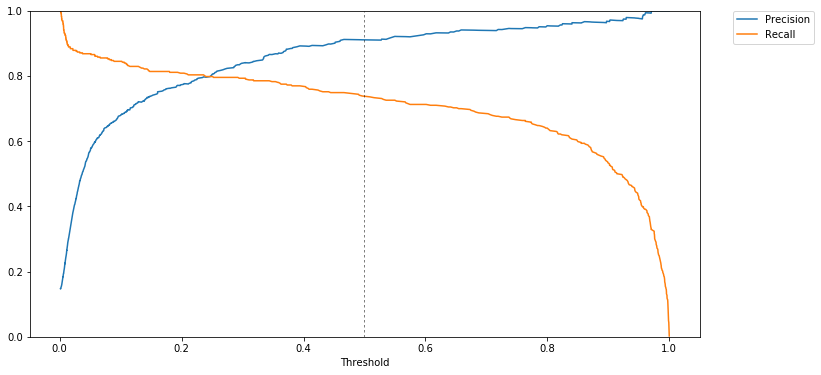

In [1032]:
plot_pr_curve(model_gb2)
plt.show()

              precision    recall  f1-score   support

       False       0.97      0.99      0.98       564
        True       0.94      0.85      0.89       103

   micro avg       0.97      0.97      0.97       667
   macro avg       0.95      0.92      0.94       667
weighted avg       0.97      0.97      0.97       667



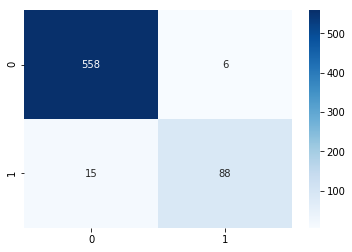

In [1052]:
threshold_gb = 0.4
predictions_model_gb2 = model_gb2.predict_proba(validate_X)
predictions_model_gb2= np.where(predictions_model_gb2[:,1] >= threshold_gb, True, False)
print(classification_report(validate_y, predictions_model_gb2))
sns.heatmap(confusion_matrix(validate_y,predictions_model_gb2), annot=True, cmap='Blues', fmt='g');

Adjusting the decision threshold to 40% reducses the precison from 97% to 94% but increases recall from 81% to 85%.

## Comparison of Classifiers

In [1039]:
# Create function to extract relevent info from classification report
def report_to_df(report):
    report = [x.split(' ') for x in report.split('\n')]
    header = ['class']+[x for x in report[0] if x!='']
    values = []
    for row in report[3:-5]:
        row = [value for value in row if value!='']
        if row!=[]:
            values.append(row)
    df_report = pd.DataFrame(data = values, columns = header)
    return df_report

In [1054]:
final_models = pd.concat([report_to_df(classification_report(validate_y, predictions_tuned_dtree)),
                          report_to_df(classification_report(validate_y, predictions_tuned_rf)),
                          report_to_df(classification_report(validate_y, predictions_model_gb2))])

final_models.insert(0, 'classifier', ['Decision Tree', 'Random Forest', 'Gradient Boosting'])
final_models.insert(1, 'threshold', [threshold_dtree, threshold_rf, threshold_gb])
final_models = final_models.drop(['class','support'], axis=1)
final_models

,classifier,threshold,precision,recall,f1-score
0,Decision Tree,0.5,0.90,0.80,0.85
0,Random Forest,0.4,0.91,0.83,0.87
0,Gradient Boosting,0.4,0.94,0.85,0.89


It can be observed from the above metrics that gradient boosting model predicted churning customers on the validation set more accurately than the decision tree and random forest model.

A more insightful way to compare model performance is to visualize the model at every threshold level. To do this, the PR curve is generated for each model. The average precision score summerize each curve and measures the AUC of the PR curve.

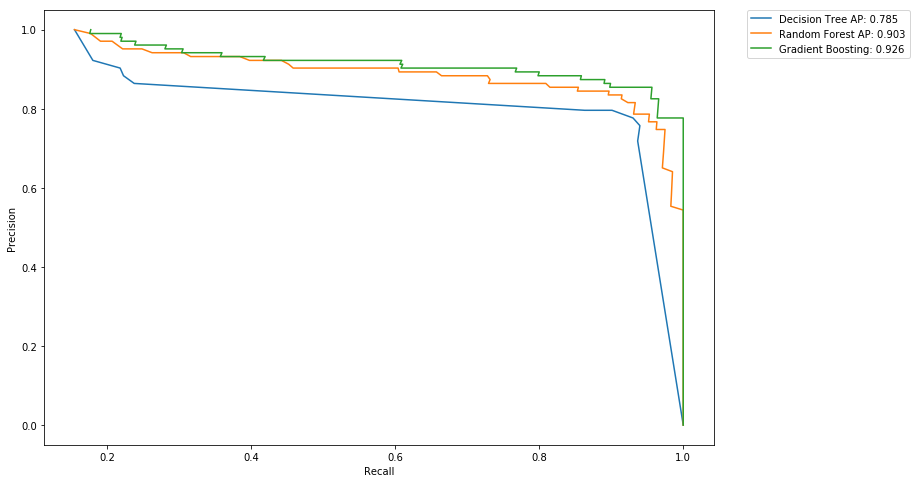

In [1037]:
# Plotting precision against recall for each classifier.
predictions_model_dtree = tuned_dtree.predict_proba(validate_X)[:,1]
dtree_precision, dtree_recall, _ = precision_recall_curve(validate_y, predictions_model_dtree, pos_label=True)

predictions_model_rf = tuned_rf.predict_proba(validate_X)[:,1]
rf_precision, rf_recall, _ = precision_recall_curve(validate_y, predictions_model_rf, pos_label=True)

prediction_model_gb2 = model_gb2.predict_proba(validate_X)[:,1]
gb_precision, gb_recall, _ = precision_recall_curve(validate_y, prediction_model_gb2, pos_label=True)

# Calculating average precision score. 
dtree_auc = average_precision_score(validate_y, predictions_model_dtree, pos_label=True)
rf_auc = average_precision_score(validate_y, predictions_model_rf, pos_label=True)
gb_auc = average_precision_score(validate_y, prediction_model_gb2, pos_label=True)


plt.figure(figsize=(12,8))
plt.plot(dtree_precision, dtree_recall, label = ('Decision Tree AP: %.3f' % dtree_auc))
plt.plot(rf_precision, rf_recall, label = ('Random Forest AP: %.3f' % rf_auc))
plt.plot(gb_precision, gb_recall, label=('Gradient Boosting: %.3f' % gb_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

The curve representing the gradient boosting model is closest to the top right corner for the graph, in addition the average precision score or area under the curve for this model is the highest of the three scores, at 92.6%.

## Final Testing of each Model

The test_X and test_y data splits have been untouched up until this point. It would be ideal to fit and predict each model on these splits to conduct final testing on the performance of each model.

In [1097]:
# Tuned decision tree model at default threshold. 
final_predictions_dtree = tuned_dtree.predict(test_X)

# Tuned random forest model at 40% threshold. 
final_predictions_rf = tuned_rf.predict_proba(test_X)
final_predictions_rf = np.where(final_predictions_rf[:,1] >= threshold_rf, True, False)

# Tuned gradient boosting model at 40% threshold.
final_predictions_gb2 = model_gb2.predict_proba(test_X)
final_predictions_gb2= np.where(final_predictions_gb2[:,1] >= threshold_gb, True, False)

final_models = pd.concat([report_to_df(classification_report(test_y, final_predictions_dtree)),
                          report_to_df(classification_report(test_y, final_predictions_rf)),
                          report_to_df(classification_report(test_y, final_predictions_gb2))])

final_models.insert(0, 'classifier', ['Decision Tree', 'Random Forest', 'Gradient Boosting'])
final_models.insert(1, 'threshold', [threshold_dtree, threshold_rf, threshold_gb])
final_models = final_models.drop(['class','support'], axis=1)
final_models

,classifier,threshold,precision,recall,f1-score
0,Decision Tree,0.5,0.79,0.74,0.77
0,Random Forest,0.4,0.88,0.80,0.84
0,Gradient Boosting,0.4,0.82,0.71,0.76


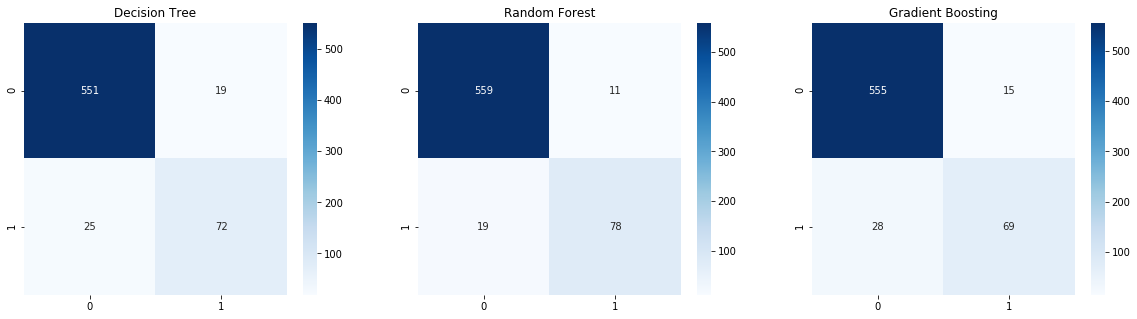

In [1124]:
# Plot confusion matrix for each model
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
sns.heatmap(confusion_matrix(test_y, final_predictions_dtree), annot=True, cmap='Blues', fmt='g', ax=ax1)
ax1.set_title('Decision Tree')
sns.heatmap(confusion_matrix(test_y,final_predictions_rf), annot=True, cmap='Blues', fmt='g', ax=ax2)
ax2.set_title('Random Forest')
sns.heatmap(confusion_matrix(test_y, final_predictions_gb2), annot=True, cmap='Blues', fmt='g', ax=ax3)
ax3.set_title('Gradient Boosting')
plt.show()

With unseen data, it appears that all three models perform weaker than on the training and validation sets. Both the decision and tree and gradient boosting model had a significant reduction in precision and recall. The random forest performed slightly worse with the test set than it did with the validation set, and overall was the strongest model among the three. 

Therefore, for the purpose of identifying customers that are potentially churning, it is recommended to use the model utilzing the random forest algorithm based on results from the test set. 